# 3D Geometric Model of Inflated Dunnage Bag - Reduction in Void

## Assumptions:

1. Material is rigid
2. Idealized geometry
3. Not rate dependent
4. Mass is constant
5. Temperature has no effect on the material or the inflated air

## Import Libraries:

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt, numpy as np
from scipy.interpolate import spline
from math import pi #import pi function for simple reference

## Functions:

In [15]:
#Find volume from length, width and diameter
def updateVolume(width,length,diameter):
    LengthLong = width - float(pi*diameter)/2 
    AreaLong = diameter*LengthLong + float(pi*diameter**2)/4
    LengthShort = length - float(pi*diameter)/2
    AreaShort = diameter*LengthShort + float(pi*diameter**2)/4
    VolumeSphere = float(1/6)*(diameter**3)*(pi)
    return (AreaLong*LengthShort) + (AreaShort*LengthLong) + VolumeSphere

In [16]:
#Update the Pressure using Ideal Gas Law
def updatePressure(mass,volume):
    return mass*8.15*300/volume

In [17]:
#Get the mass using the Ideal Gas Law
def updateMass(pressure,volume):
    return(pressure*volume)/(8.15*300.0)

In [18]:
#Get stess from Barlow's formula
def updateStress(diameter,pressure): 
    return (diameter*pressure)/(2*1)

In [19]:
#Find the new length using the strain calculated
def updateLength(length,strain):
    ChangeInLength = length*strain 
    return length+ChangeInLengthdirectory

In [20]:
#Get strain from stress-strain curve
def getStrain(stress,strain,stress_barlow):
    index = np.array(stress).searchsorted(stress_barlow)#find index from barlow's stress value
    x2 = strain[index-1] #find strain value to left
    x1 = strain[index] #find strain value to right
    y2 = stress[index-1] #find stress value to left
    y1 = stress[index] #find stress value to right
    return x1 + (stress_barlow-y1)*(x2 - x1)/(y2 - y1)

## Import Data for Stress-Strain:

In [21]:
#for root,dirs,files in os.walk('C:\Users\Inance\Documents\Thesis\Experiments\Tensile_Tests\Trial_Round\Tensile_test_mts\Inance_pp_mts\8_5_2016_300mm_min_GREEN\WAR'):
   # for file in files:
tensile=pd.read_csv(r'C:\Users\Inance\Documents\Thesis\Experiments\Tensile_Tests\Trial_Round\Tensile_test_mts\Inance_pp_mts\8_5_2016_300mm_min_GREEN\WARP\specimen1.1.txt',header=None,names=['Time','Load','Extension','Strain','Crosshead','Extensometer'])
load=np.array(tensile.Load)
crosshead=np.array(tensile.Crosshead)
sig=load*70*0.4*10**3
eps=(90-crosshead)/90
#print(sig,eps)

## Main A - Just Inflated:

In [22]:
def MainA(w,l,d,m,V,P,sig_b,sig,eps):
    # Main A - loop parameters:
    max_iter = 200 #maximum number of iterations
    m_tol = 0.0005 #mass tolerance
    i = 0 #starting number of iteration
    m_diff = 10.0 #
    m_old = 100 #old mass 
    
    
    while (m_diff >= m_tol and i < max_iter):
        P.append(P[0]) #update Pressure
    
        sig_b.append(updateStress(d,P[i+1])) #get Stress using Barlow's formula
    
        epsa.append(getStrain(sig,eps,sig_b[i+1])) #call Strain function
    
        l.append(updateLength(l[0],epsa[i+1]))#get updated length
    
        V.append(updateVolume(w,l[i+1],d)) #get Volume
    
        m.append(updateMass(P[i+1],V[i+1])) #initial mass from Ideal Gas Law
    
        #Loop constraints
        m_diff = np.abs(m[i+1] - m_old) #calculate abs difference between old m and new m
        m_old = m[i+1] #set the old m equal to the current m for the next loop


        i+=1 #increment i to loop
        return l,d,m,V,P,sig_b

## Main B - Reduction in Void:

In [23]:
def MainB(w,l,d,m,V,P,sig_b,sig,eps):

    d_red=[0.3] #diameter with reduction main
    m_red = [m[2]] #end mass of Main A, starting mass for Main B
    V_red = [V[2]] #end volume of Main A, starting volume for Main B
    P_red = [P[2]] #end pressure of Main A, starting pressure for Main B
    sig_b_red = [sig_b[2]] #end barlow stress of Main A, starting barlow stress for Main B
    epsa_red = [epsa[2]] #end strain of Main A, starting strain for Main B
    l_red = [l[2]] #end length of Main A, starting length for Main B
    
    #Loop parameters:
    max_iter = 5
    k = 0 #number of iterations
    l_tol = 0.0005
    l_diff = 10.0
    l_old = 10

    while l_diff >= l_tol and k < max_iter:
    
        V_red.append(updateVolume(w,l_red[k],d_red[0])) #get Volume
    
        P_red.append(updatePressure(m_red[0],V_red[k+1]))
    
        sig_b_red.append(updateStress(d_red[0],P_red[k+1]))
    
        epsa_red.append(getStrain(sig,eps,sig_b_red[k+1]))
    
        l_red.append(updateLength(l_red[0],epsa_red[k+1]))#get updated length
    
        #Loop constraints
        l_diff = np.abs(l_red[k+1] - l_old) #calculate abs difference between old V and new V
        l_old = l_red[k+1] #set the old V equal to the current V for the next loop
        print(d_red[0],'\t',P_red[k+1],'\t',epsa_red[k+1],'\t',V_red[k+1],'\t',sig_b_red[k+1])
        k+=1 #increment k to loop 
        
        return l_red,d_red,m_red,V_red,P_red,sig_b_red

## MAIN - Time loop:

In [24]:
time = 10
t=0
#Constants:
w=1.5
d=0.5
dur=1.0

#Initial values:
l=[2.0] #initial length
P=[100000]  #initial pressure absolute!!!
V=[10]
m=[updateMass(P[0],V[0])] #initial mass from Ideal Gas Law
sig_b = [updateStress(d,P[0])] #initial stress form Barlows
epsa = [0.0]

#Input parameters for Main B:
w=1.5

Main_A = [0]

print('d_red','\t','P_red','\t\t\t','epsa_red','\t\t','V_red','\t','sig_b_red')
    
while t<=time:
    Main_A.append(MainA(w,l,d,m,V,P,sig_b,sig,eps))  

    #MainB(w,l,d,m,V,P,sig_b,sig,eps)
    t+=1

d_red 	 P_red 			 epsa_red 		 V_red 	 sig_b_red


## Input Graphs:

### Stress vs Strain

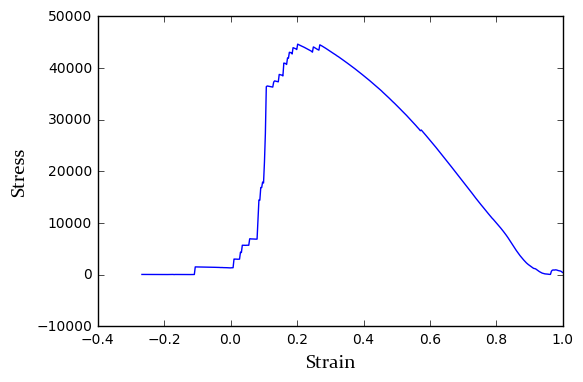

<function matplotlib.pyplot.close>

In [25]:
#Stress vs Strain - Data generated by Tensile Test
plt.figure(1)
axis_font = {'fontname':'Constantia', 'size':'14'}
plt.show(plt.plot(eps,sig))
plt.ylabel("Stress",**axis_font),plt.xlabel("Strain",**axis_font)
plt.close

### Pressure vs Barlow's Stress

In [26]:
plt.figure(2)
axis_font = {'fontname':'Constantia', 'size':'14'}
plt.show(plt.plot(sig_b_red,P_red))
plt.xlabel("Barlow's stress",**axis_font),plt.ylabel("Pressure",**axis_font)
plt.close

NameError: name 'sig_b_red' is not defined

## Iteration Graphs:

### Pressure vs Iteration number

In [ ]:
#Pressure vs Iteration number 
plt.figure(3)
axis_font = {'fontname':'Constantia', 'size':'14'}
plt.show(plt.plot(range(len(P_red)),P_red))
plt.ylabel("Pressure",**axis_font),plt.xlabel("Iteration number",**axis_font)
plt.close

### Diameter vs Iteration number

In [ ]:
#Diameter vs Iteration number 
plt.figure(4)
axis_font = {'fontname':'Constantia', 'size':'14'}
plt.show(plt.plot(range(len(d_red)),d_red))
plt.ylabel("Diameter",**axis_font),plt.xlabel("Iteration number",**axis_font)
plt.close

### Strain vs Iteration number

In [ ]:
#Strain vs Iteration number 
plt.figure(5)
axis_font = {'fontname':'Constantia', 'size':'14'}
plt.show(plt.plot(range(len(epsa_red)),epsa_red))
plt.ylabel("Calculated Strain",**axis_font),plt.xlabel("Iteration number",**axis_font)
plt.close

### Volume vs Iteration number

In [ ]:
#Volume vs Iteration number 
plt.figure(6)
axis_font = {'fontname':'Constantia', 'size':'14'}
plt.show(plt.plot(range(len(V_red)),V_red))
plt.ylabel("Volume",**axis_font),plt.xlabel("Iteration number",**axis_font)
plt.close

### Barlow's Stress vs Iteration number

In [27]:
#Barlow's Stress vs Iteration number 
plt.figure(7)
axis_font = {'fontname':'Constantia', 'size':'14'}
plt.show(plt.plot(range(len(sig_b_red)),sig_b_red))
plt.ylabel("Barlow's Stress",**axis_font),plt.xlabel("Iteration number",**axis_font)
plt.close

NameError: name 'sig_b_red' is not defined